In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from lightgbm import plot_importance
import joblib
from hnmchallenge.constant import *
from hnmchallenge.data_reader import DataReader

from hnmchallenge.evaluation.python_evaluation import map_at_k, recall_at_k
from hnmchallenge.feature_manager import FeatureManager
from hnmchallenge.datasets.last_week_last_week import LWLWDataset
from hnmchallenge.datasets.last_month_last_week_dataset import LMLWDataset
from hnmchallenge.datasets.last_month_last_4day import LML4DDataset
from hnmchallenge.datasets.last_month_last_day import LMLDDataset
from hnmchallenge.models.itemknn.itemknn import ItemKNN
import lightgbm as lgb


/raid/home/edoardo/GitProjects/HnMChallenge/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
dataset = LML4DDataset()
dr = DataReader()

In [3]:
base_load_path = dataset._DATASET_PATH / "lgbm_models"

In [4]:
VERSION = 0
NAME = "cutf_200_ItemKNN_tw_True_rs_False"
#NAME = "dataset_letsgo4"
DATASET = f"{NAME}_{VERSION}.feather"
MODEL_NAME = f"lgbm_{DATASET}.pkl"

In [5]:
model=joblib.load(base_load_path/MODEL_NAME)

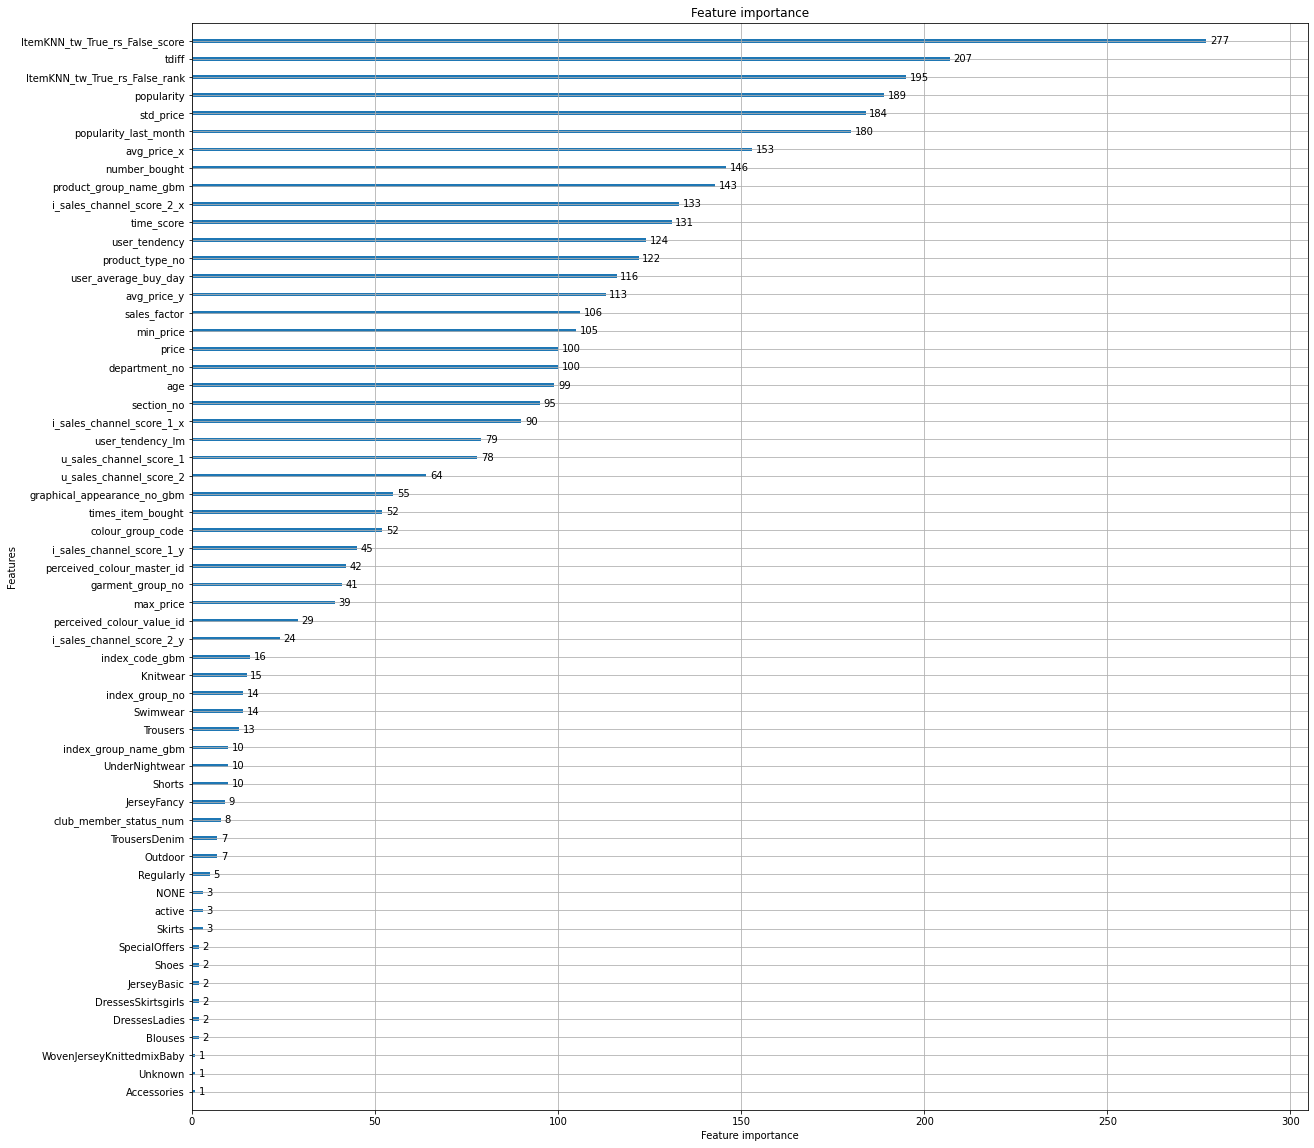

In [6]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_importance(model, ax=ax)
plt.show()

In [7]:
model.best_iteration_

129

In [8]:
import re
features = pd.read_feather(dataset._DATASET_PATH / f"dataset_dfs/full/{DATASET}")
features = features.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))

# Remember to use the bert_ntree_limit when taking the predictions

In [9]:
features.head()

,customer_id,article_id,ItemKNN_tw_True_rs_False_score,ItemKNN_tw_True_rs_False_rank,colour_group_code,i_sales_channel_score_2_x,i_sales_channel_score_1_x,department_no,Accessories,Blouses,...,user_average_buy_day,u_sales_channel_score_2,u_sales_channel_score_1,time_score,tdiff,times_item_bought,graphical_appearance_no_gbm,index_code_gbm,index_group_name_gbm,product_group_name_gbm
0,0,1871,0.008221,1.0,71,0.835887,0.164113,1747,0,0,...,95.5,1.0,0.0,1.0,0.004855,1.0,0,7,4,3
1,0,2067,0.007990,2.0,9,0.846024,0.153976,1747,0,0,...,95.5,1.0,0.0,1.0,0.004855,1.0,0,7,4,3
2,0,2257,0.007978,3.0,73,0.935973,0.064027,1747,0,0,...,95.5,1.0,0.0,1.0,0.004855,1.0,0,7,4,3
3,0,6262,0.006484,4.0,9,0.991320,0.008680,1722,0,0,...,95.5,1.0,0.0,1.0,0.004855,1.0,0,0,0,3
4,0,2085,0.006474,5.0,10,0.756471,0.243529,1643,0,0,...,95.5,1.0,0.0,1.0,0.004855,1.0,0,7,4,0


In [10]:
features.columns

Index(['customer_id', 'article_id', 'ItemKNN_tw_True_rs_False_score',
       'ItemKNN_tw_True_rs_False_rank', 'colour_group_code',
       'i_sales_channel_score_2_x', 'i_sales_channel_score_1_x',
       'department_no', 'Accessories', 'Blouses', 'Dressed', 'DressesLadies',
       'DressesSkirtsgirls', 'JerseyBasic', 'JerseyFancy', 'Knitwear',
       'Outdoor', 'Shirts', 'Shoes', 'Shorts', 'Skirts', 'SocksandTights',
       'SpecialOffers', 'Swimwear', 'Trousers', 'TrousersDenim',
       'UnderNightwear', 'Unknown', 'WovenJerseyKnittedmixBaby',
       'garment_group_no', 'index_group_no', 'popularity',
       'popularity_last_month', 'number_bought', 'perceived_colour_master_id',
       'perceived_colour_value_id', 'product_type_no', 'section_no', 'price',
       'avg_price_x', 'max_price', 'min_price', 'std_price', 'sales_factor',
       'i_sales_channel_score_2_y', 'i_sales_channel_score_1_y', 'active',
       'age', 'club_member_status_num', 'Monthly', 'NONE', 'None', 'Regularly',
  

In [11]:
cat = [
    "index_code_gbm",
    "product_group_name_gbm",
    "index_group_name_gbm",
    "graphical_appearance_no_gbm",
]

cat_index = [i for i, c in enumerate(features.columns) if c in cat]
print(cat_index)

for col in cat:
    features[col] = pd.Categorical(features[col])

[62, 63, 64, 65]


In [12]:
customer_article_df = features[[DEFAULT_USER_COL, DEFAULT_ITEM_COL]].copy()
X = features.drop([DEFAULT_USER_COL, DEFAULT_ITEM_COL], axis=1)

In [13]:
y_pred = model.predict(X, num_iteration=model.best_iteration_)

In [14]:
customer_article_df["predicted_score"] = y_pred

In [15]:
customer_article_df

,customer_id,article_id,predicted_score
0,0,1871,2.329429
1,0,2067,2.711234
2,0,2257,1.678551
3,0,6262,0.464631
4,0,2085,-1.463085
...,...,...,...
253902995,1371979,13794,0.554390
253902996,1371979,2659,-1.031363
253902997,1371979,289,-0.396383
253902998,1371979,4065,1.340773


In [16]:
sorted_scores = customer_article_df.sort_values([DEFAULT_USER_COL, "predicted_score"], ascending=[True, False])

In [17]:
sorted_scores.head(20)

,customer_id,article_id,predicted_score
1,0,2067,2.711234
0,0,1871,2.329429
2,0,2257,1.678551
11,0,1971,1.024560
13,0,1880,0.928339
15,0,197,0.754843
3,0,6262,0.464631
14,0,5486,0.176675
39,0,4275,0.091753
41,0,12,0.091425


In [18]:
sorted_scores_index = sorted_scores.reset_index(drop=True)

In [19]:
cutoff = sorted_scores_index.groupby(DEFAULT_USER_COL).size().values
i=0 
filter_indices = []
for cut in cutoff:
    filter_indices.extend(range(i, i+12))
    i=i+cut

In [20]:
cutoff.mean()

185.06319334101082

In [21]:
filter_indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 600,
 601,
 602,
 603,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 800,
 801,
 802,
 803,
 804,
 805,
 806,
 807,
 808,
 809,
 810,
 811,
 1000,
 1001,
 1002,
 1003,
 1004,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1200,
 1201,
 1202,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1209,
 1210,
 1211,
 1400,
 1401,
 1402,
 1403,
 1404,
 1405,
 1406,
 1407,
 1408,
 1409,
 1410,
 1411,
 1600,
 1601,
 1602,
 1603,
 1604,
 1605,
 1606,
 1607,
 1608,
 1609,
 1610,
 1611,
 1800,
 1801,
 1802,
 1803,
 1804,
 1805,
 1806,
 1807,
 1808,
 1809,
 1810,
 1811,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2200,
 2201,
 2202,
 2203,
 2204,
 2205,
 2206,
 2207,
 2208,
 2209,
 2210,
 2211,
 2400,
 2401,
 2402,
 2403,
 2404,
 2405,
 2406,
 2407,
 2408,
 2409,
 241

In [22]:
final_df = sorted_scores_index.loc[filter_indices]

In [23]:
final_df

,customer_id,article_id,predicted_score
0,0,2067,2.711234
1,0,1871,2.329429
2,0,2257,1.678551
3,0,1971,1.024560
4,0,1880,0.928339
...,...,...,...
253902907,1371979,49,1.480914
253902908,1371979,1943,1.459306
253902909,1371979,226,1.433096
253902910,1371979,158,1.424210


In [24]:
final_final_df = final_df.drop("predicted_score", axis=1)

In [25]:
dataset.create_submission(final_final_df, sub_name="gbm")